In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
# import ipywidgets as widgets

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

# Introduction

This analysis explores an online retail store dataset, aiming to uncover key insights about customer purchasing behavior, product performance, and revenue distribution. The dataset, sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail), contains transactional data, including invoice details, product codes, quantities sold, prices, and customer IDs.

Understanding the data wasn’t a straightforward process—I didn’t just find all the insights laid out neatly. Instead, I went through a lot of trial and error (a.k.a. messing around and figuring things out). What follows is a structured presentation of those findings, but in reality, this wasn’t a single smooth journey—it was an iterative process of discovery.

Now, let’s break down the dataset and dive into the analysis.

## Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Looking at above data, I can see that i can analyze product, country and customer data. Rest of them are supplementary of it. Also looking at StockCode and Description, i feel there should be one to one correspondence as both represent single product under the hood.

Let's look at what kind of transaction we have in our dataset

#### Quantity vs UnitPrice

In [11]:
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Looking at above numbers, both quantity and unit price go below zero and there are extreme number in both sides. Now with this there are 9 segments of transactions. Made with Quantity > 0 or = 0 or < 0 matched with UnitPrice > 0 or = 0 or < 0.

Let's look at these one by one.

In [17]:
# there are no entries in this segment
# so quantity has to be something for to be recorded in database

df[(df["Quantity"] == 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [42]:
# from looks of it, these are inventory management and since UnitPrice == 0, it won't affect our
# revenue calculations. The reason i was able to say inventory management is because looking
# at descriptions, there are entries like damaged, re-adjustment, faulty, etc. Went to chatgpt
# with those all descriptions and confirmed these are non sales transactions

df[(df["UnitPrice"] == 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [25]:
# these are real sales which we are going to analyze later

df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [27]:
# debt adjustment of business

df[(df["Quantity"] > 0) & (df["UnitPrice"] < 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [33]:
# looking at quantity being negative and unitprice > 0. It seems like returned or cancelled section
# of dataset. Also looking through internet i found out that invoice number starting with 'C' are credit
# note for business to indicate like returns or cancellation. Here i can see discount field.
# Let's see if all the invoice number in this section starts with 'C'

creditnote_section = df[(df["Quantity"] < 0) & (df["UnitPrice"] > 0)]
creditnote_section.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [36]:
# so yeah all the invoice number starts with 'C'

creditnote_section["InvoiceNo"].str.startswith('C').unique()

array([ True])

In [38]:
# there are no entries here, and it makes sense as according to my information there are no
# business transactions with both quantity and unit price being -ve.

df[(df["Quantity"] < 0) & (df["UnitPrice"] < 0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


#### Business dealing with wholesellers

Looking above, i can easily see that there are wholeseller with retail customers. Looking at distribution of it

In [55]:
np.percentile(df[df["Quantity"] > 0]["Quantity"], 70)  # so 70% of data is of retail and rest of them are wholeseller

np.float64(8.0)

In [64]:
(df["Quantity"] < 0).value_counts()

Quantity
False    531285
True      10624
Name: count, dtype: int64

In [65]:
# let's look at number perspective
# yeah threshold == 8 seems contrived but who knows maybe you have bought 8 product even if
# you are retail customer
# don't worry about -ve quantity inclusion in first because as seen above they are about 10K
# which is very small compared to 380K

print(f"About these are retail customer {df[df['Quantity'] <= 8].shape[0]}")
print(f"About these are wholesellers {df[df['Quantity'] > 8].shape[0]}")

About these are retail customer 384953
About these are wholesellers 156956


#### StockCode with alphabets only

In [45]:
# i was searching through Credit note transactions and there i saw some stockcode which
# only has alphabets as stockcode value. There are three types of Stockcode here, one is
# stockcode with only numbers, second one is number + alphabet and lastly only alphabet
# The reason i am interested in alphabets stockcode is because eyeballing some of the transactions
# these seems like internal business stuff and i don't want to include them in my analysis
# for revenue, etc

stockcodes = df["StockCode"].apply(str)
alphacode = df[~stockcodes.str.contains(r"\d", na=False)]
alphacode.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,NaN,United Kingdom


In [48]:
# looking below without examning further will feel like we have to include those entries
# while doing revenue and other analysis but later looking at those extreme values these
# are small in number and internal business stuff won't really matter for trends and stuff

alphacode[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,2796.000000,2796.000000
mean,3.581545,260.852240
std,67.374006,1321.062127
min,-1350.000000,-11062.060000
25%,1.000000,16.722500
50%,1.000000,18.000000
75%,2.000000,161.900000
max,1600.000000,38970.000000


In [50]:
# Later on i looked at each and saw that they really don't matter in my analysis
# yeah 'BOYS PARTY BAG' and it's equivalent will feel like they are real products
# being sold but since they are low in number and it is negligible compared to rest of
# the products

alphacode["Description"].unique()

array(['POSTAGE', 'Discount', 'DOTCOM POSTAGE', 'Manual', 'Bank Charges',
       'SAMPLES', 'AMAZON FEE', nan, 'BOYS PARTY BAG', 'GIRLS PARTY BAG',
       'PADS TO MATCH ALL CUSHIONS', 'Adjust bad debt', 'CRUK Commission'],
      dtype=object)

#### StockCode as representation of product

First look at description having many stockcodes

In [3]:
# what about description having many stockcode

# removing unitprice == 0 because these are according to me inventory management
# and looking at those descriptions they include such as "damage", "clean"
# so it makes sense these corresponds to many stockcodes

stockcodes = df[df["UnitPrice"] != 0].groupby("Description").agg(
    List=("StockCode", lambda x: list(set(x))),
    TotalNo=("StockCode", lambda x: len(list(set(x))))
).reset_index()
unique_nums = np.sort(stockcodes["TotalNo"].unique())
unique_nums

array([1, 2, 6])

In [4]:
# eyeballing these entries feel like they are same but just one is capital and other is lower

double_sc = stockcodes[stockcodes["TotalNo"] == 2]
double_sc.head()

,Description,List,TotalNo
46,3 GARDENIA MORRIS BOXED CANDLES,"[85034a, 85034A]",2
61,3 WHITE CHOC MORRIS BOXED CANDLES,"[85034B, 85034b]",2
72,3D DOG PICTURE PLAYING CARDS,"[84558A, 84558a]",2
74,3D SHEET OF CAT STICKERS,"[84559b, 84559B]",2
75,3D SHEET OF DOG STICKERS,"[84559A, 84559a]",2


In [5]:
# let's confirm this hypothesis for all entries

check = double_sc["List"].apply(lambda x: str(x[0]).upper() == str(x[1]).upper())
check.unique()

array([ True, False])

In [6]:
# so i have to replace the second on with first one in original dataset
# and lastly i have to make each stockcode as string and use upper method

double_sc[check == False].head()

,Description,List,TotalNo
856,COLOURING PENCILS BROWN TUBE,"[10133, 10135]",2
858,COLUMBIAN CANDLE RECTANGLE,"[72131, 72133]",2
859,COLUMBIAN CANDLE ROUND,"[72128, 72130]",2
1124,EAU DE NILE JEWELLED PHOTOFRAME,"[85024B, 85023B]",2
1371,FRENCH FLORAL CUSHION COVER,"[20840, 20837]",2


In [7]:
# similarly adding this to previous stockcode dict

stockcodes[stockcodes["TotalNo"] == 6]

,Description,List,TotalNo
2083,"METAL SIGN,CUPCAKE SINGLE HOOK","[82613b, 82613c, 82613A, 82613B, 82613C, 82613a]",6


In [8]:
stockcode_dict = {row["Description"]: row["List"][0] for _, row in double_sc[check == False].iterrows()}
stockcode_dict[stockcodes[stockcodes["TotalNo"] == 6]["Description"].item()] = stockcodes[stockcodes["TotalNo"] == 6]["List"].item()[0]

def change_sc(row):
    if row["Description"] in stockcode_dict:
        return stockcode_dict[row["Description"]]
    return row["StockCode"]


final_df = df.copy()
final_df["StockCode"] = final_df.apply(change_sc, axis=1)
final_df["StockCode"] = final_df["StockCode"].astype(str).str.upper()

Now looking at stockcode having many descriptions

In [139]:
descriptions = final_df[final_df["UnitPrice"] != 0].groupby("StockCode").agg(
    List=("Description", lambda x: list(set(x))),  # or "unique"
    TotalNo=("Description", lambda x: len(list(set(x))))  # or "nunique"
).reset_index()

descriptions["TotalNo"].unique()

array([1, 2, 3, 4])

In [146]:
# let's look at each records manually
# and yes all the descriptions point to same product
# thus finally we can use stockcode as representation of product

# for _, row in descriptions[descriptions["TotalNo"] > 1].iterrows():
#     print(row["List"])

#### Return vs Cancel orders

In [155]:
# future roop here, so as i was studying credit note transactions. There i saw these two
# transactions at last. Here the customer has placed a very very big order and then cancelled
# within few minutes. These types really distort the results. There are many such like on in
# January. So later while analyzing and finding trends, also take credit note transactions
# into account so that they will cancel out each other and will show correct revenue.
# Yeah i can remove those transactions but i am not confident where should i place
# threshold. Such that above threshold are returns and below are cancelled

final_df[final_df["CustomerID"] == 16446]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


#### Time Period of Data

In [153]:
# lastly let's understand the time period when the data is collected
# from looks of it, we have one year worth of data

dates = final_df["InvoiceDate"]
print(dates.head())
print("\n")

# checking if date is sorted or not
print("Starting date: ", dates.iloc[0])
print("Is Monotonic Increasing: ", dates.is_monotonic_increasing)
print("Ending date: ", dates.iloc[-1])

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


Starting date:  2010-12-01 08:26:00
Is Monotonic Increasing:  True
Ending date:  2011-12-09 12:50:00


## Analysis

#### Trends and Seasonal Patterns

In business, there are two types of sales: regular sales, which occur daily or frequently and serve as the base revenue generator, and seasonal sales, which happen during specific periods and typically generate higher revenue than regular sales.

To analyze the revenue trend of the business, I will first examine the daily revenue plot. However, this alone is not sufficient to determine whether the business's sales have increased, as I only have one year of data, and the revenue growth could be due to seasonal effects.

In [47]:
# creating dataframe for analysis

final_df["TotalPrice"] = final_df["Quantity"] * final_df["UnitPrice"]
# filtering actual product sales and returns
# refer to above eda about quantity vs unit price
sales_df = final_df[final_df["UnitPrice"] > 0]
sales_df = sales_df[sales_df["StockCode"].str.contains(r"\d", na=False)]

# the reason i have included those with "Quantity" < 0 because i want the returns to cancel
# thus showing real results

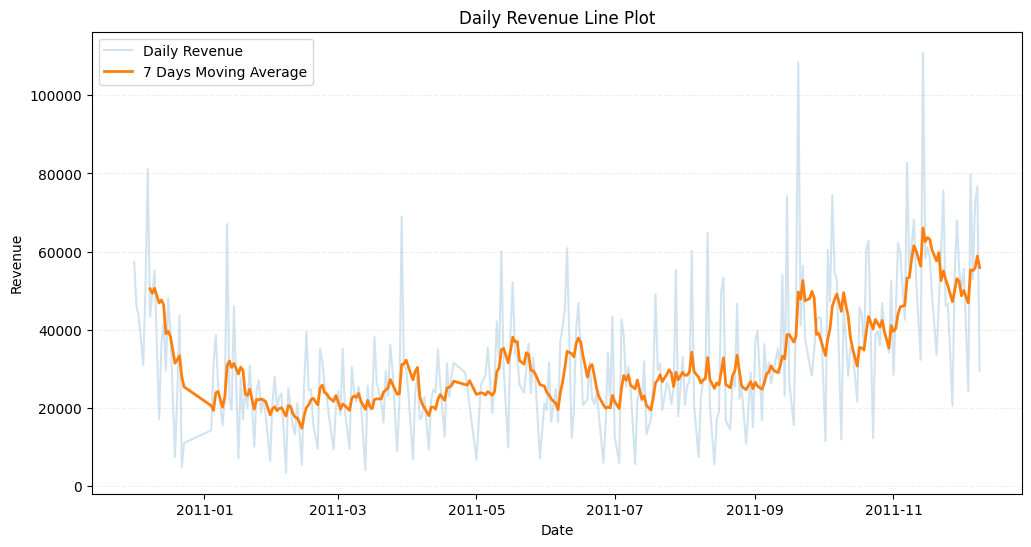

In [96]:
# Plotting daily revenue along with a smoothed version using a 7-day moving average to identify trends

dailyrev = sales_df.groupby(sales_df["InvoiceDate"].dt.date)["TotalPrice"].sum()

plt.figure(figsize=(12, 6))
plt.plot(dailyrev, alpha=0.2, label="Daily Revenue")
plt.plot(dailyrev.rolling(window=7).mean(), linewidth=2, label="7 Days Moving Average")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(axis='y', linestyle='--', alpha=0.2)  # Add gridlines for y-axis
plt.title("Daily Revenue Line Plot")
plt.legend()
plt.show()

Looking at above plot, you can infer that business revenue per day has increased towards the end and thus business is improving. But this is wrong because at the end which are november, december. These are holiday seasons and based on product descriptions, it appears that this business is a gift shop. Given this, the increase in daily revenue towards the end of the year is likely driven by seasonal demand, particularly during the holiday season.

Therefore, I cannot conclusively determine the overall revenue trend from this dataset alone. Additional data from different time periods would be required to separate seasonal effects and accurately assess business growth.

But we can comment upon monthly effects and see in which month the business is doing good and more

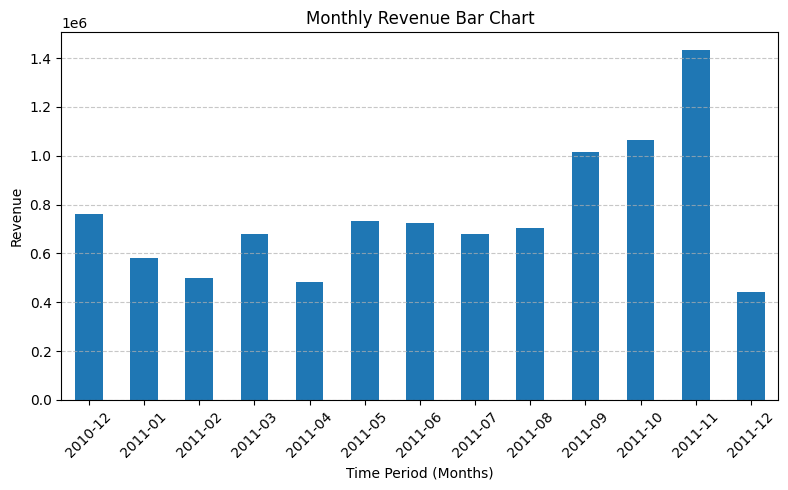

In [90]:
# plotting bar char with lines

monthlyrev = sales_df.groupby(sales_df["InvoiceDate"].dt.to_period("M"))["TotalPrice"].sum()

plt.figure(figsize=(8, 5))
monthlyrev.plot(kind="bar")
plt.title('Monthly Revenue Bar Chart')
plt.xlabel('Time Period (Months)')
plt.ylabel('Revenue')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for y-axis
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

From the above plot, we can see that revenue peaks in September, October, and November, with a significant increase compared to other months. There are troughs such as in month January, February and April where revenue is low. However, I cannot make a fair comparison for December, as the dataset contains only the first 9 days of December 2011. To ensure consistency, I will compare the first 9 days of December 2010 and 2011.

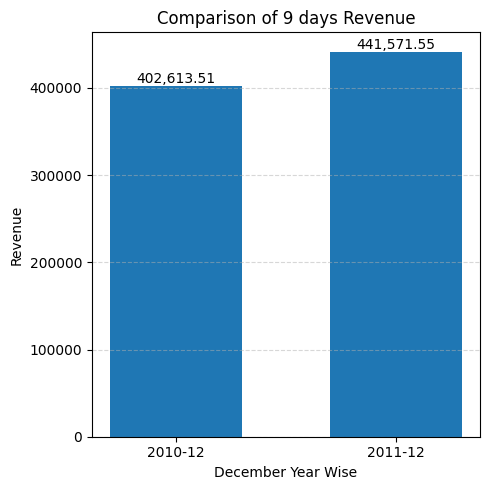

In [93]:
december_revenue = [
    sales_df[sales_df["InvoiceDate"] < pd.to_datetime("2010-12-10")]["TotalPrice"].sum(),
    sales_df[sales_df["InvoiceDate"].dt.to_period("M") == pd.Period("2011-12")]["TotalPrice"].sum()
]

plt.figure(figsize=(5, 5))
bars = plt.bar(["2010-12", "2011-12"], december_revenue, width=0.6)

# Add numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.2f}', 
             ha='center', va='bottom', fontsize=10)

    
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xlabel("December Year Wise")
plt.ylabel("Revenue")
plt.title("Comparison of 9 days Revenue")
plt.tight_layout()
plt.show()

So both december have similar revenue generated albeit 2011 having little more revenue.

#### Market Region Analysis

Let's look where our business is doing most of the business

In [10]:
# let's get revenue and total transactions made in each country

regional_df = sales_df.groupby("Country").agg(
    TotalRevenue=("TotalPrice", "sum"),
    TotalTransactions=("InvoiceNo", "nunique")
)

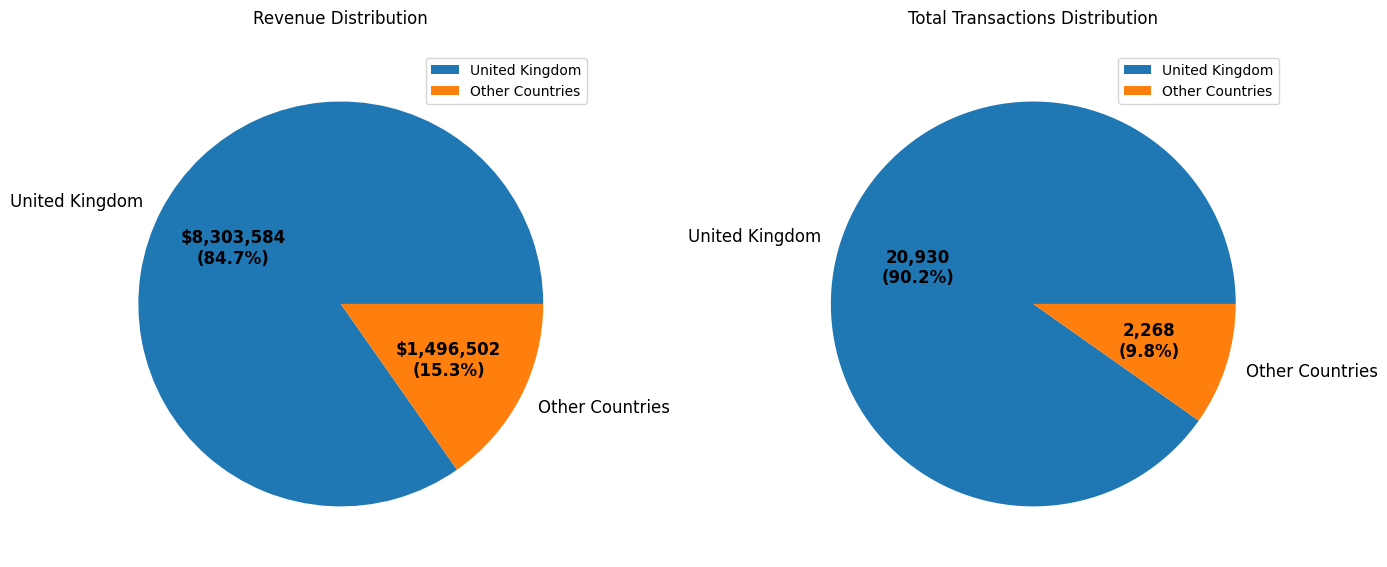

In [92]:
# comparing primary market (UK) with other countries

uk_vs_others = pd.concat([
    regional_df.loc[['United Kingdom']],
    regional_df.drop('United Kingdom').sum().to_frame().T.rename(index={0: 'Other Countries'})
])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

# revenue pie distribution
patches, texts, autotexts = axes[0].pie(
    uk_vs_others["TotalRevenue"], 
    labels=uk_vs_others.index,
    autopct=lambda p: f'${p*sum(uk_vs_others["TotalRevenue"])/100:,.0f}\n({p:.1f}%)',
    textprops={'fontsize': 12}
)

# Style the numbers
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# Add title and legend
axes[0].set_title('Revenue Distribution', pad=20)
axes[0].legend(patches, uk_vs_others.index, loc='upper right')

# total transactions pie distribution
patches, texts, autotexts = axes[1].pie(
    uk_vs_others["TotalTransactions"], 
    labels=uk_vs_others.index,
    autopct=lambda p: f'{p*sum(uk_vs_others["TotalTransactions"])/100:,.0f}\n({p:.1f}%)',
    textprops={'fontsize': 12}
)

# Style the numbers
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# Add title and legend
axes[1].set_title('Total Transactions Distribution', pad=20)
axes[1].legend(patches, uk_vs_others.index, loc='upper right')

plt.tight_layout()
plt.savefig("UK.png")
plt.show()

Looking at above result, United Kingdom is primary market of this business and rest contribute about 15% to total revenue. Still having 10 times less than UK transactions it takes extra 5% from total revenue meaning some of the country have placed big orders.

Let's study other markets a bit for business to know where to invest to expand.

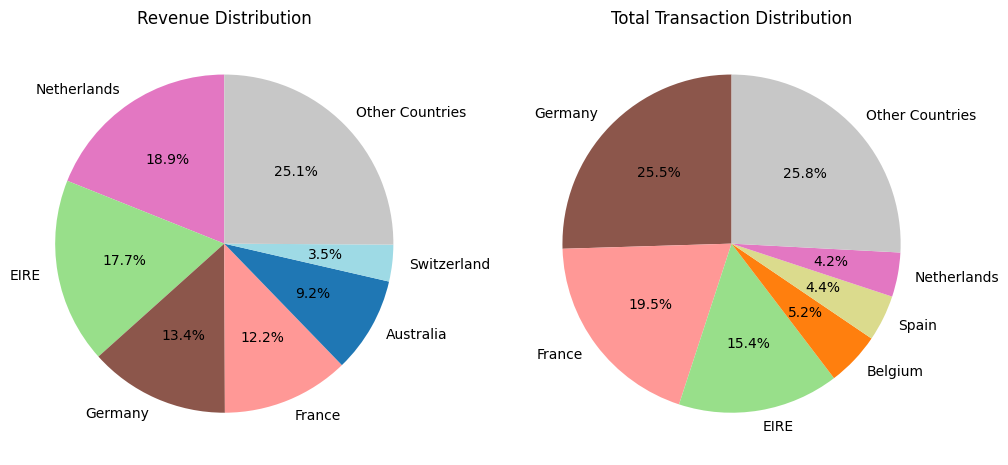

In [89]:
other_countries = regional_df.drop('United Kingdom')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

revenue_sorted = other_countries["TotalRevenue"].sort_values(ascending=False)
top6 = revenue_sorted.head(6)
rest_countries = pd.Series({ "Other Countries": revenue_sorted[6:].sum()})
combined_revenue = pd.concat([top6, rest_countries])

trx_sorted = other_countries["TotalTransactions"].sort_values(ascending=False)
top6 = trx_sorted.head(6)
rest_countries = pd.Series({ "Other Countries": trx_sorted[6:].sum()})
combined_trx = pd.concat([top6, rest_countries])

countries = combined_revenue.index.union(combined_trx.index)
colormap = plt.cm.tab20  # Good for up to 20 distinct colors
colors = [colormap(i) for i in np.linspace(0, 1, len(countries))]
country_colors = dict(zip(countries, colors))

axes[0].pie(combined_revenue, labels=combined_revenue.index,
            startangle=90, autopct="%1.1f%%",
            colors=[country_colors[country] for country in combined_revenue.index])
axes[0].set_title("Revenue Distribution")

axes[1].pie(combined_trx, labels=combined_trx.index,
            startangle=90, autopct="%1.1f%%",
            colors=[country_colors[country] for country in combined_trx.index])
axes[1].set_title("Total Transaction Distribution")

plt.show()

Looking at this market, countries like netherlands and Australia have higher revenue albeit having small transactions whereas countries like germany and france having higher transactions but lower revenue is generated thus low Average order value.

Now to study whether these countries revenue is generated from wholesale or retail customers, let's divert a bit and understand how to remove those entries where order is place and whole order is returned.

In [67]:
# let's get all the cancelled or return records
cancelled_orders = sales_df[sales_df['InvoiceNo'].astype(str).str.startswith('C')].copy()
cancelled_orders["Quantity"] = -1 * cancelled_orders["Quantity"]

# now merging so that we can check and remove those entries
# now let get all those entries where customer has bought the product but returned fully
matched_sales = sales_df[sales_df["Quantity"] > 0].merge(cancelled_orders,
                                  on=["CustomerID", "StockCode", "Quantity", "UnitPrice", "Country"],
                                  suffixes=('_sale', '_cancel'))

# filter only cases where the cancellation happened after the sale
matched_sales = matched_sales[matched_sales["InvoiceDate_cancel"] > matched_sales["InvoiceDate_sale"]]

# these were me checking if entries in this df makes sense or not, and yes it makes sense
# to remove them
"""
matched_sales["CancelDelta"] = matched_sales["InvoiceDate_cancel"] - matched_sales["InvoiceDate_sale"]
days = np.sort(matched_sales["CancelDelta"].dt.days.unique())


def display_matched_sales(canceldelta):
    display(matched_sales[matched_sales["CancelDelta"].dt.days == canceldelta])


widgets.interact(display_matched_sales, canceldelta=days)
"""

# there are entries such as Buy Buy Return. In this case both of the buy will be included
# like [Buy1 Return] and [Buy2 Return]. Thus we are removing those entries here which is
# [Buy2 Return]
# look at those examples here:
# sales_df[(sales_df["CustomerID"] == 17850) & (sales_df["StockCode"] == "22632")]
# matched_sales[(matched_sales["CustomerID"] == 17850) & (matched_sales["StockCode"] == "22632")]
matched_sales = matched_sales.drop_duplicates(
    subset=["StockCode", "Quantity", "UnitPrice", "CustomerID", "Country"],
    keep="first"
)

# now getting those records which are real sales to customer also taking into account
# of returned products
real_sales = sales_df[sales_df["Quantity"] > 0].copy()

# Create a unique key for matching
real_sales['UniqueKey'] = real_sales[['InvoiceNo', 'CustomerID', 'StockCode', 'Quantity', 'UnitPrice']].astype(str).agg('|'.join, axis=1)
matched_sales['UniqueKey'] = matched_sales[['InvoiceNo_sale', 'CustomerID', 'StockCode', 'Quantity', 'UnitPrice']].astype(str).agg('|'.join, axis=1)

# removing entries in matched_sales from real_sales
real_sales = real_sales[~real_sales["UniqueKey"].isin(matched_sales["UniqueKey"])]
real_sales = real_sales.drop(columns=['UniqueKey'])

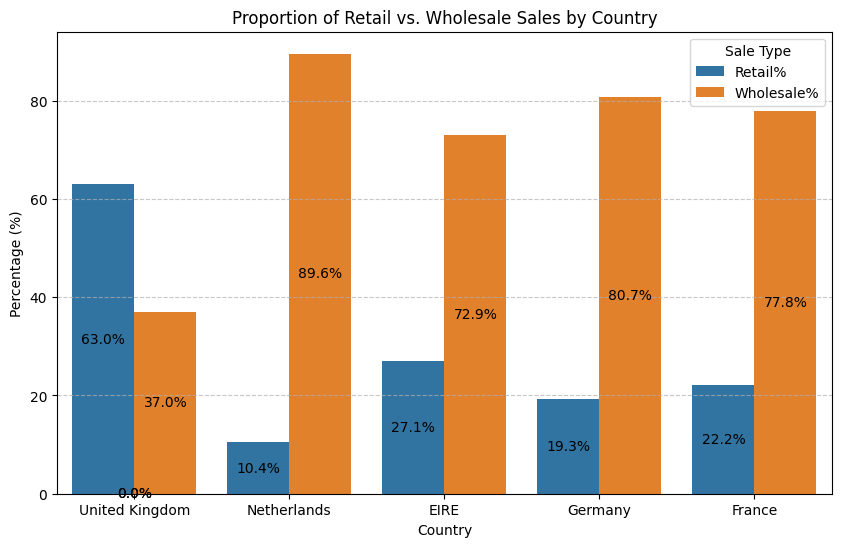

In [91]:
# Now let's see the distribution of retail customer vs wholeseller between few countries

countries = ["United Kingdom", "Netherlands", "EIRE", "Germany", "France"]

# taking 5 as threshold ( no reason to back this up )
number_data = real_sales.groupby("Country").agg(
    RetailNo=("Quantity", lambda q: sum((q <= 5) * 1)),
    WholesaleNo=("Quantity", lambda q: sum((q > 5) * 1)),
    Total=("Quantity", "count")
).loc[countries]

# Calculate proportions (percentage)
number_data['Retail%'] = (number_data['RetailNo'] / number_data['Total']) * 100
number_data['Wholesale%'] = (number_data['WholesaleNo'] / number_data['Total']) * 100

# Melt data for Seaborn
number_data_melted = number_data[['Retail%', 'Wholesale%']].reset_index().melt(id_vars='Country')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=number_data_melted,
    x='Country',
    y='value',
    hue='variable',
)

plt.title('Proportion of Retail vs. Wholesale Sales by Country')
plt.xlabel('Country')
plt.ylabel('Percentage (%)')
plt.legend(title='Sale Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.1f}%',
        (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2),
        ha='center',
        va='center',
        color='black'
    )

plt.show()

From this i can conclude that most outside UK are wholsellers and thus due to having high quantity they are generating high revenue.

**Key Findings from Regional Market Analysis**

1. UK Dominance:
   - The United Kingdom is the primary market, contributing **85% of total revenue**.  
   - Other countries collectively generate **15% of total revenue** with **10x fewer transactions**, indicating larger average order sizes.  

2. Top Revenue-Contributing Countries (Outside UK):
   - Netherlands & Australia: High revenue despite fewer transactions, suggesting larger bulk orders.  
   - Germany & France: High transaction volume but lower revenue, indicating smaller order sizes.  

3. Retail vs. Wholesale Sales:
   - UK has a mix of **retail and wholesale customers**.  
   - Outside the UK, **wholesale customers dominate**, leading to high revenue per transaction.  

We can now go to each country and understand what types of product being sold and every other thing but i will leave that cause currently i am looking at above overall than researching particular thing.

#### Product Level Analysis

First let's separate out those which are sold in large quantities and those which are sold in small. This way i can look at two perspective, where wholeseller are preferring and where retail customers are preferring.

In [146]:
# threshold = 5 (no reason just my preconceived notion)
# using real_sales compared to sales_df because i don't require returns to analyze

small_sales = real_sales[real_sales["Quantity"] <= 5].groupby("StockCode")["TotalPrice"].sum()
large_sales = real_sales[real_sales["Quantity"] > 5].groupby("StockCode")["TotalPrice"].sum()

In [166]:
# retail customer analysis

# Here there are no products which can be seen as dominating product driving
# most revenue of the business. Here the most revenue product contributes 1%
# to whole revenue of business

print(small_sales.sort_values(ascending=False).head())
print("\nContribution to Revenue by 22423 =>", round((small_sales.loc["22423"] / small_sales.sum()) * 100, 1), "%")

StockCode
22423    41763.90
47566    18264.13
22720    15261.08
23245    12799.12
85066    12001.24
Name: TotalPrice, dtype: float64

Contribution to Revenue by 22423 => 1.7 %


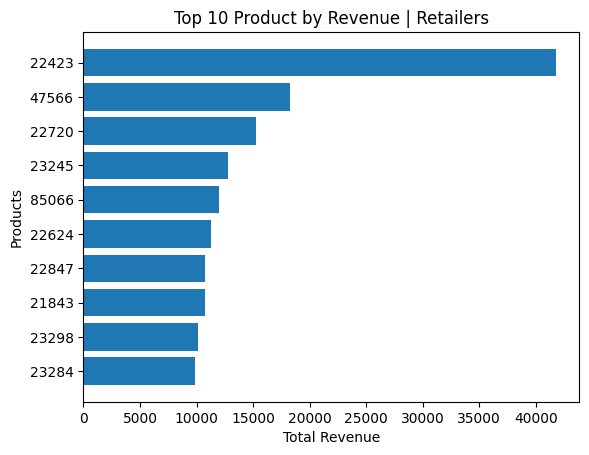

In [172]:
temp = small_sales.sort_values(ascending=False).head(10).sort_values()
plt.barh(temp.index, temp)
plt.xlabel("Total Revenue")
plt.ylabel("Products")
plt.title("Top 10 Product by Revenue | Retailers")
plt.show()

In [167]:
# wholeseller analysis

# Here there are no products which can be seen as dominating product driving
# most revenue of the business. Here the most revenue product contributes 1%
# to whole revenue of business

print(large_sales.sort_values(ascending=False).head())
print("\nContribution to Revenue by 22423 =>", round((large_sales.loc["22423"] / large_sales.sum()) * 100, 1), "%")

StockCode
22423     128895.69
85123A     91924.71
85099B     87221.06
47566      80365.25
23084      64957.33
Name: TotalPrice, dtype: float64

Contribution to Revenue by 22423 => 1.7 %


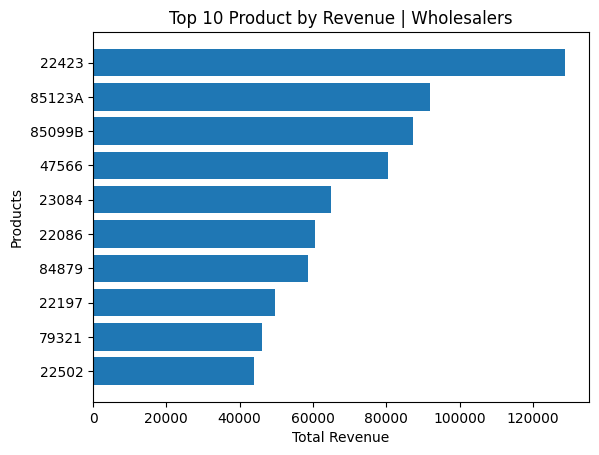

In [174]:
temp = large_sales.sort_values(ascending=False).head(10).sort_values()
plt.barh(temp.index, temp)
plt.xlabel("Total Revenue")
plt.ylabel("Products")
plt.title("Top 10 Product by Revenue | Wholesalers")
plt.show()

Key Findings from Product Level Analysis:

1. Segmentation of Sales
   - Products were analyzed separately for **small quantity sales (retail customers)** and **large quantity sales (wholesalers).**  
   - A threshold of **5 units per transaction** was used to differentiate retail vs. wholesale purchases.

2. Retailer Preferences
   - The top product **(StockCode: 22423)** contributes **1.7% of total revenue** from retail sales.  
   - No single product dominates, and revenue is distributed across multiple products.

3. Wholesaler Preferences
   - The same product **(StockCode: 22423)** also leads in wholesale sales, generating **1.7% of total business revenue.**  
   - However, wholesale sales are **more evenly distributed** across multiple products, with no dominant item significantly driving revenue.

4. Overall Business Impact
   - The revenue contribution from individual products is relatively **small**, meaning the business is not highly dependent on a single item.  
   - A broad product portfolio seems to be the key revenue driver rather than a few bestsellers.

## Conclusion  

This wraps up my analysis for now, but there are still several areas I plan to explore further.  

**Future Explorations**  

Exploratory Data Analysis (EDA):  

1. Investigating potential **duplicate data issues**.  
2. Exploring **StockCodes that only contain alphabets** and their significance.  
3. Using statistical methods to determine a **threshold between retailers and wholesalers**.  

Deeper Analysis:

1. Examining the **nature of internal business transactions** in more detail.  
2. Studying data in different time frames.
3. Conducting **customer-level segmentation** to identify distinct buying behaviors.  
4. Categorizing products into three key segments:  
   - High Quantity, Low Revenue
   - High Revenue, Low Quantity
   - Balanced
5. Addressing outstanding questions listed in `example_question.md`.  

Lastly, I also plan to read all the [research papers](https://archive.ics.uci.edu/dataset/352/online+retail) that have used this dataset to gain additional insights.  